In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd 
import geopandas as gpd 

import rasterio       # For reading .tif files
import matplotlib.pyplot as plt  # For plotting
import numpy as np
import pdb 
import xarray as xr

import rioxarray as xrio
import cv2

import project3_tools
import importlib

from affine import Affine
from rasterio.transform import from_origin
from rasterio.features import geometry_mask

from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap, Normalize


In [2]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [3]:
#load burn area
ba = gpd.read_file('/data/IMFSE/PythonCourse/PontdeVilomara/burntArea/burnAreaPdV2022.shp')

In [4]:
#input files
file_f = '/data/IMFSE/PythonCourse/LCP/lcp_pgd80.tif'
file_atm = '/data/IMFSE/PythonCourse/MNH/FCAST_model3.nc'


In [5]:
#load terrain from fire
ds_f = xrio.open_rasterio(file_f, decode_times=False)
terrain_f = ds_f.isel(band=0)
mask=np.where(terrain_f.values==-9999,0,1).astype(np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, np.ones((21,21))) # to remove point on the border
terrain_f.values[np.where(mask==0)]=-9999

terrain_f_ori = terrain_f.copy()
terrain_f_ori.values[np.where(mask==0)]=-9999

In [6]:
#load terrain from atm from netcdf and set topo in xr dataArray with crs 4326
ds_atm = xr.open_dataset(file_atm, decode_times=False)
terrain_atm = ds_atm.topography
lat_atm = ds_atm.lat.values[:,0]
lon_atm = ds_atm.lon.values[0,:]

terrain_atm_wgs= xr.DataArray(
    terrain_atm.values, 
    coords=[("y", lat_atm), ("x", lon_atm)],  # Assign coordinates
    dims=["y", "x"],  # Define dimension names
#    attrs={"crs": "EPSG:4326"}  # Add CRS as an attribute (EPSG:4326 = WGS 84)
)

terrain_atm_wgs = terrain_atm_wgs.rio.write_crs("EPSG:4326",inplace=True)


In [7]:
# Now reproject the terrain_atm_wgs 
#to a the same projection and extdend as terrain_f
terrain_atm = terrain_atm_wgs.rio.reproject_match(terrain_f, nodata=-9999)

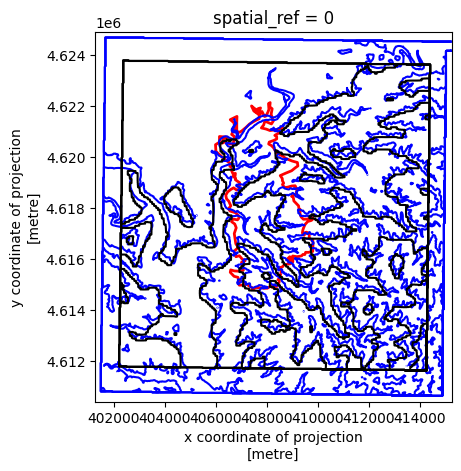

In [8]:
#plot
levels = np.linspace(0, 1000, 10)

ax = plt.subplot(111)
terrain_f.plot.contour(levels=levels,cmap='b',ax=ax)
terrain_atm.plot.contour(levels=levels,ax=ax,cmap='k')
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none',linewidth=2)
ax.set_aspect(1)

#ax = plt.subplot(122)
#terrain_atm.plot(vmin=0,vmax=1000,ax=ax)
#ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='k', facecolor='none')
#ax.set_aspect(1)

In [9]:
#############################################
################load SRTM ###################
#############################################

In [10]:
file_srtm = '/data/IMFSE/PythonCourse/LCP/srtm30m_pdV.tif'
#load terrain from fire
ds_srtm = xrio.open_rasterio(file_srtm, decode_times=False)
terrain_srtm = ds_srtm.isel(band=0)
terrain_srtm = terrain_srtm.rio.reproject_match(terrain_f, nodata=-9999)

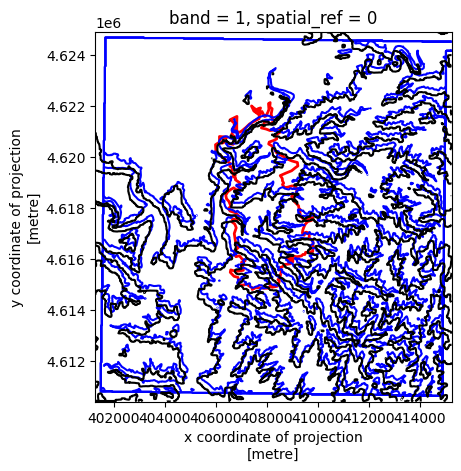

In [11]:
#plot
levels = np.linspace(0, 1000, 10)
ax = plt.subplot(111)
terrain_f.plot.contour(levels=levels,cmap='b',ax=ax)
terrain_srtm.plot.contour(levels=levels,ax=ax,cmap='k')
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none',linewidth=2)
ax.set_aspect(1)


In [12]:
#############################################
################estimate shift###############
#############################################

In [13]:
importlib.reload(project3_tools)
terrain_f, warp_matrix = project3_tools.aligned_terrain(terrain_f.copy(), terrain_srtm)

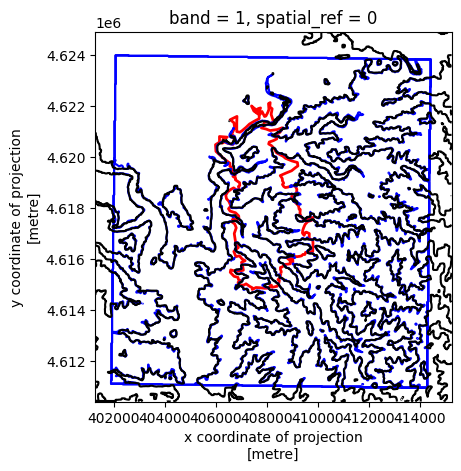

In [14]:
#plot aligned terrain
levels = np.linspace(0, 1000, 10)
ax = plt.subplot(111)
terrain_f.plot.contour(levels=levels,cmap='b',ax=ax)
terrain_srtm.plot.contour(levels=levels,ax=ax,cmap='k')
ba.to_crs(ds_f.rio.crs).plot(ax=ax,edgecolor='r', facecolor='none',linewidth=2)
ax.set_aspect(1)

In [15]:
translation = warp_matrix[:,2] * terrain_srtm.rio.resolution()[0]
print('translation of x={:5.3f} y={:5.3f} m'.format(*translation))

translation of x=92.041 y=-207.072 m


In [16]:
#############################################
################fuelMap in ba###############
#############################################

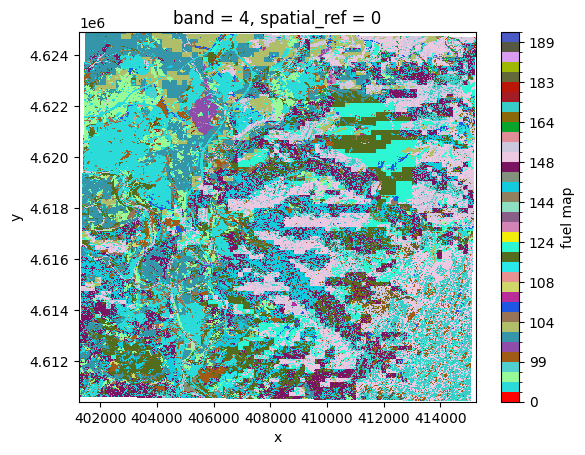

In [17]:
%matplotlib inline
fuelmap_f = ds_f.isel(band=3)
fuelmap_f.name = 'fuel map'

N = len(np.unique(fuelmap_f.values)) -1  # Number of colors
colors = np.random.rand(N, 3) #plt.cm.hsv(np.linspace(0, 1, N))
cmap_fm = mcolors.ListedColormap(colors)
colors[0,:] = [1,0,0]

# Define the boundaries of each color segment
bounds = np.unique(fuelmap_f.values)[1:]  # from 1 to 10
bounds = np.append(bounds, 9999)
norm_fm = mcolors.BoundaryNorm(bounds, cmap_fm.N)

#set no data to not be ploted
nodata_value = -9999
fuelmap_f = fuelmap_f.where(fuelmap_f != nodata_value)

fuelmap_f.plot(cmap=cmap_fm,norm=norm_fm)


In [18]:
maskBa = project3_tools.create_mask_from_ba( fuelmap_f, ba)

In [19]:
masked_da = fuelmap_f.where(maskBa == 1)
gdf_fuelMap = masked_da.to_dataframe().dropna().reset_index().drop(columns=['x','y','band','spatial_ref'])

In [20]:
gdf_fuelMap

,fuel map
0,93.0
1,93.0
2,123.0
3,93.0
4,93.0
...,...
37811,149.0
37812,149.0
37813,149.0
37814,149.0


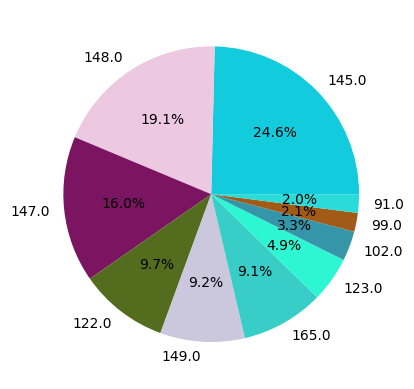

In [21]:
value_counts = gdf_fuelMap['fuel map'].value_counts()

# Plot a pie chart with the top N categories
top_n = 10  # Plot the top 10 most frequent categories
value_counts.head(top_n).plot(kind='pie', autopct='%1.1f%%',colors=cmap_fm(norm_fm(value_counts.index)))

plt.ylabel('')  # Remove y-label for pie chart
plt.show()



In [22]:
#############################################
################aspect vs fuelmap############
#############################################

In [23]:


def compute_aspect_with_projection(dem: xr.DataArray) -> xr.DataArray:
    """
    Compute the aspect from a DEM (Digital Elevation Model) DataArray, retaining
    the projection and coordinate reference system (CRS) information.
    
    Parameters:
    - dem: xarray.DataArray of the elevation data, with spatial coordinates (e.g., 'x', 'y')
    
    Returns:
    - aspect_da: xarray.DataArray of the aspect in degrees (0-360), retaining the same CRS and projection as the input
    """

    # Compute gradients (slopes) in y and x directions
    grad_y, grad_x = np.gradient(dem, dem['y'], dem['x'])

    # Compute aspect using arctan2, with the formula arctan2(grad_x, -grad_y)
    aspect = np.arctan2(grad_x, -grad_y)

    # Convert aspect from radians to degrees and ensure the range is [0, 360]
    aspect = np.degrees(aspect)
    aspect = (aspect + 360) % 360

    # Create a new DataArray with the same coordinates, dimensions, and projection as the input
    aspect_da = xr.DataArray(
        aspect,
        coords=dem.coords,  # Keep the same coordinates
        dims=dem.dims,      # Keep the same dimensions
        attrs=dem.attrs     # Keep the same attributes (projection, CRS, etc.)
    )

    # Update the name and units to reflect that this is the aspect
    aspect_da.name = 'aspect'
    aspect_da.attrs['units'] = 'degrees'
    aspect_da.attrs['description'] = 'Aspect (degrees clockwise from North)'

    return aspect_da

In [24]:
#compute aspect
aspect_f = compute_aspect_with_projection(terrain_f)
aspect_f_ori = compute_aspect_with_projection(terrain_f_ori)

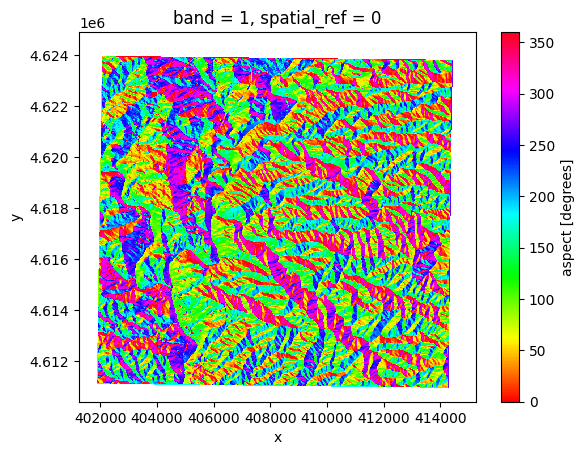

In [25]:
# plot aspect

# Define the colors: red at 0, white at 180, blue at 360
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Red -> White -> Blue

# Create a colormap
cmap = LinearSegmentedColormap.from_list("red_white_blue", colors, N=256)

# Create a normalization object for the range 0 to 360
norm = Normalize(vmin=0, vmax=360)
aspect_f.where(terrain_f!=-9999).plot(cmap='hsv', vmin=0, vmax=360)